In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pickle
import tensorflow as tf
import wordcloud

In [3]:
df = pd.read_csv("spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
data = df.copy() ## make a copy of the data
data.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

#rename the label and text columns
data = data.rename(columns={"v1":"label", "v2":"text"})
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
data.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

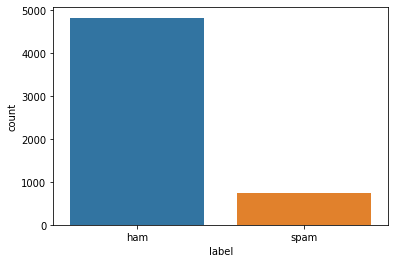

In [6]:
sns.countplot(data['label'])
plt.show()

In [7]:
data['label'] = data['label'].map( {'spam': 1, 'ham': 0} )

In [8]:
data_ham  = data[data['label'] == 0].copy()
data_spam = data[data['label'] == 1].copy()

In [9]:
#Word Cloud FUnction

def show_wordcloud(df, title):
    text = ' '.join(df['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

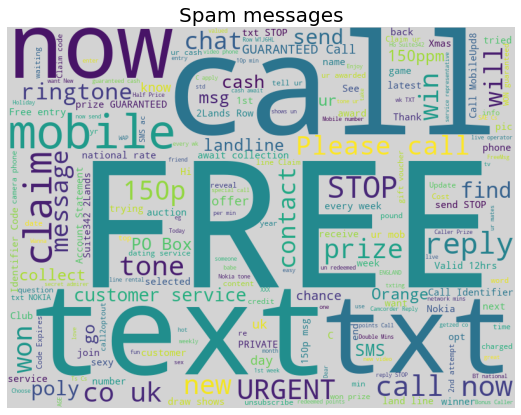

In [10]:
show_wordcloud(data_spam, "Spam messages")

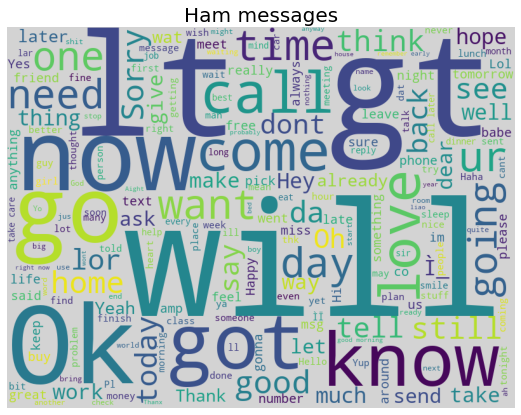

In [11]:
show_wordcloud(data_ham, "Ham messages")

In [14]:

#Preparing the dataset for training
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# helps in model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

# split data into train and test set
from sklearn.model_selection import train_test_split


In [15]:
X = data['text'].values
y = data['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [16]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)
#You should not apply fit_on_texts to your test data.



In [17]:
# integer encode the documents
encoded_train = t.texts_to_sequences(X_train)
encoded_test = t.texts_to_sequences(X_test)
print(encoded_train[0:2])

[[38, 30, 8, 5, 273, 1989, 81, 116, 26, 11, 1656, 322, 10, 53, 18, 299, 30, 349, 1990], [799, 15, 2555, 1442, 1127, 192, 2556, 171, 12, 98, 1991, 44, 195, 1657, 2557, 1992, 2558, 21, 9, 4, 203, 1025, 225]]


In [18]:
# pad documents to a max length of 8words
max_length = 8
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')
print(padded_train)

[[ 322   10   53 ...   30  349 1990]
 [1992 2558   21 ...  203 1025  225]
 [  83 1443    4 ...    2 3794 3795]
 ...
 [1477   30 2063 ...  239   30 2064]
 [ 763 1679 1161 ...    0    0    0]
 [   8  155   20 ...    8  290  175]]


In [19]:
vocab_size = len(t.word_index) + 1

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 24, input_length=max_length))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 24)             190920    
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               96500     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               100200    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [20]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# fit the model
model.fit(x=padded_train,
         y=y_train,
         epochs=50,
         validation_data=(padded_test, y_test), verbose=1,
         callbacks=[early_stop]
         )

Train on 4457 samples, validate on 1115 samples
Epoch 1/50
4457/4457 [==============================] - 5s 1ms/sample - loss: 0.1765 - accuracy: 0.9313 - val_loss: 0.0934 - val_accuracy: 0.9803
Epoch 2/50
4457/4457 [==============================] - 1s 317us/sample - loss: 0.0488 - accuracy: 0.9841 - val_loss: 0.0832 - val_accuracy: 0.9812
Epoch 3/50
4457/4457 [==============================] - 1s 294us/sample - loss: 0.0173 - accuracy: 0.9944 - val_loss: 0.1255 - val_accuracy: 0.9803
Epoch 4/50
4457/4457 [==============================] - 1s 276us/sample - loss: 0.0022 - accuracy: 0.9993 - val_loss: 0.1649 - val_accuracy: 0.9803
Epoch 5/50
4457/4457 [==============================] - 1s 257us/sample - loss: 7.7261e-06 - accuracy: 1.0000 - val_loss: 0.2470 - val_accuracy: 0.9812
Epoch 6/50
4457/4457 [==============================] - 1s 261us/sample - loss: 3.9132e-08 - accuracy: 1.0000 - val_loss: 0.2776 - val_accuracy: 0.9821
Epoch 7/50
4457/4457 [==============================] - 1s

In [21]:
model.save("spam_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: spam_model/assets


In [23]:
with open('spam_model/tokenizer.pkl', 'wb') as output:
   pickle.dump(t, output, pickle.HIGHEST_PROTOCOL)

In [24]:
#Making predictions
s_model = tf.keras.models.load_model("spam_model")
with open('spam_model/tokenizer.pkl', 'rb') as input:
    tokenizer = pickle.load(input)

In [27]:
sms = ["We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB "]
sms_proc = tokenizer.texts_to_sequences(sms)
sms_proc = pad_sequences(sms_proc, maxlen=max_length, padding='post')
pred = (model.predict(sms_proc) > 0.5).astype("int32").item()
print(pred)

1
